In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("dorothea_smaller.csv")

In [2]:
data_out = pd.DataFrame(data['y.train'])
data_in = data.drop(columns = ['y.train','Unnamed: 0'])

In [3]:
l_bound = 0.05  #If data varies in less than 5% of cases, it is deemed not significant
u_bound = 1 - l_bound
data_cut = data_in

In [35]:
for i in range(len(data_in.columns)):  #Note: this loop takes approx. 9 mins to run (for my crappy laptop)
    if sum(data_in.iloc[:,i]) <= (l_bound * len(data_in)):
        data_cut = data_cut.drop(data_in.columns[i], axis=1)
    elif sum(data_in.iloc[:,i]) >= (u_bound * len(data_in)):
        data_cut = data_cut.drop(data_in.columns[i], axis=1)

data_cut.to_csv('data_cut.csv')

print("Variables: " + str(len(data_cut.columns)))

Variables: 123


In [4]:
data_mod = pd.read_csv("data_cut.csv")
#df.insert(124,"Output",data_out,True)
data_mod = data_mod.drop(columns = ['Unnamed: 0'])

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

In [61]:
n_PCA = 10 #Number of Principal Components

x=StandardScaler().fit_transform(data_mod.values)
data_pca = decomposition.PCA(n_components = n_PCA)
principalComponents = data_pca.fit_transform(x)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [62]:
var = data_pca.explained_variance_ratio_
sum_var = 0
for i in range(len(var)):
    sum_var = sum_var + var[i]

In [63]:
sum_var

0.15633008223919276

In [ ]:
from sklearn.model_selection import train_test_split

In [25]:
inputs = data_mod.to_numpy()

In [26]:
data_out_mod1 = (data_out + 1) / 2 #Inactive = 0, Active = 1
data_out_mod2 = 0.5 - (data_out / 2) #Inactive = 1, Active = 0
outputs = np.concatenate((data_out_mod1,data_out_mod2),axis=1)

In [27]:
train_x, test_x, train_y, test_y = train_test_split(inputs, outputs, test_size=0.25, random_state=28)

In [58]:
def sigmoid(x):
    # This is not strictly sigmoid, but more stable when handling matrices
    return .5 * (1 + np.tanh(.5 * x))
def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

learning_rate = 0.001
num_epochs = 5000

# Network architecture parameters
num_features = len(train_x[0])
num_classes = len(train_y[0])
num_hidden_nodes = 8

# Initialise weights in the range -1 to 1
np.random.seed(28)
# Hidden layer weights with shape = number of input features x number of hidden nodes
hidden_weights = np.random.uniform(-1, 1, size=(num_features, num_hidden_nodes))
hidden_bias = np.random.uniform(-1, 1, size=(1, num_hidden_nodes))
# Output layer weights with shape = number of hidden nodes x number of output classes
output_weights = np.random.uniform(-1, 1, size=(num_hidden_nodes, num_classes))
output_bias = np.random.uniform(-1, 1, size=(1, num_classes))

# For recording error and accuracy - for graph later
training_errors = []
testing_errors = []
training_accuracies = []
testing_accuracies = []

# Train for number of epochs
for epoch in range(num_epochs):

    # Forward pass
    input_layer = train_x
    # sigmoid( (W * X) + b)
    hidden_layer = sigmoid(np.dot(input_layer, hidden_weights) + hidden_bias)
    output_layer = sigmoid(np.dot(hidden_layer, output_weights) + output_bias)

    # Backpropagation using gradient descent
    # Calculate output layer error
    output_layer_error = train_y - output_layer
    # Calculate output layer derivative Note: that we just need this layers error for the bias
    output_layer_delta = output_layer_error * sigmoid_deriv(output_layer)
    output_bias_delta = np.sum(output_layer_error, axis=0)
    
    # Calculate hidden layer error (from the output layers weights and derivative
    hidden_layer_error = output_layer_delta.dot(output_weights.T)
    hidden_layer_delta = hidden_layer_error * sigmoid_deriv(hidden_layer)
    hidden_bias_delta = np.sum(hidden_layer_error, axis=0)

    # Update the weights (learning rate X layers input X layers derivative)
    output_weights += learning_rate * hidden_layer.T.dot(output_layer_delta)
    output_bias += learning_rate * output_bias_delta
    
    hidden_weights += learning_rate * input_layer.T.dot(hidden_layer_delta)
    hidden_bias += learning_rate * hidden_bias_delta

    # Every 100 epochs record error and accuracy during training
    if (epoch % 100) == 0:
        
        # Mean squared error over all errors this epoch
        error = 0.5 * np.mean(np.abs(output_layer_error)) ** 2
        training_errors.append(error)

        accuracy_count = 0
        for i in range(len(output_layer)):
          
            # Get the prediction i.e. the output with the highest value
            prediction = np.argmax(output_layer[i])
            # Get the actual label
            actual_label = np.argmax(train_y[i])
            
            # If they match the prediction was correct
            if prediction == actual_label:
                accuracy_count += 1
        accuracy = (100 / len(train_x)) * accuracy_count
        training_accuracies.append(accuracy)
        
        # Input test data to determine testing errors
        input_layer_test = test_x
        hidden_layer_test = sigmoid(np.dot(input_layer_test, hidden_weights) + hidden_bias)
        output_layer_test = sigmoid(np.dot(hidden_layer_test, output_weights) + output_bias)
        
        output_layer_error_test = test_y - output_layer_test
        error_test = 0.5 * np.mean(np.abs(output_layer_error_test)) ** 2
        testing_errors.append(error_test)
        
        accuracy_count_test = 0
        for i in range(len(output_layer_test)):
          
            prediction_test = np.argmax(output_layer_test[i])
            actual_label_test = np.argmax(test_y[i])
            
            if prediction_test == actual_label_test:
                accuracy_count_test += 1
        accuracy_test = (100 / len(test_x)) * accuracy_count_test
        testing_accuracies.append(accuracy_test)
        
        
#        print("Epoch: " + str(epoch) +
#              " Error: " + str(round(error, 5)) +
#              " Accuracy: " + str(round(accuracy, 3)) + "%" +
#              " T_Error: " + str(round(error_test, 5)) +
#              " T_Accuracy: " + str(round(accuracy_test, 3)) + "%")
                


Epoch: 0 Error: 0.19651 Accuracy: 9.833% T_Error: 0.1386 T_Accuracy: 36.5%
Epoch: 100 Error: 0.01472 Accuracy: 90.5% T_Error: 0.01632 T_Accuracy: 89.5%
Epoch: 200 Error: 0.01434 Accuracy: 90.5% T_Error: 0.01601 T_Accuracy: 89.5%
Epoch: 300 Error: 0.01392 Accuracy: 90.5% T_Error: 0.01565 T_Accuracy: 89.5%
Epoch: 400 Error: 0.01339 Accuracy: 90.5% T_Error: 0.01516 T_Accuracy: 89.5%
Epoch: 500 Error: 0.01269 Accuracy: 90.5% T_Error: 0.01447 T_Accuracy: 89.5%
Epoch: 600 Error: 0.01179 Accuracy: 90.5% T_Error: 0.01355 T_Accuracy: 89.5%
Epoch: 700 Error: 0.01073 Accuracy: 90.5% T_Error: 0.01245 T_Accuracy: 89.5%
Epoch: 800 Error: 0.00962 Accuracy: 90.667% T_Error: 0.01128 T_Accuracy: 89.5%
Epoch: 900 Error: 0.00859 Accuracy: 91.833% T_Error: 0.0102 T_Accuracy: 90.5%
Epoch: 1000 Error: 0.00772 Accuracy: 93.167% T_Error: 0.00928 T_Accuracy: 92.0%
Epoch: 1100 Error: 0.00701 Accuracy: 93.5% T_Error: 0.00853 T_Accuracy: 92.0%
Epoch: 1200 Error: 0.00643 Accuracy: 93.833% T_Error: 0.00793 T_Accurac

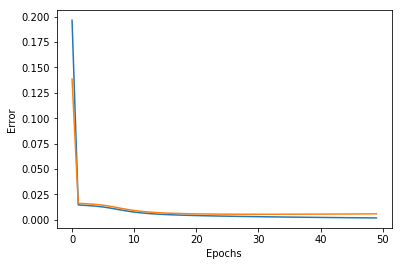

In [56]:
plt.plot(training_errors)
plt.plot(testing_errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

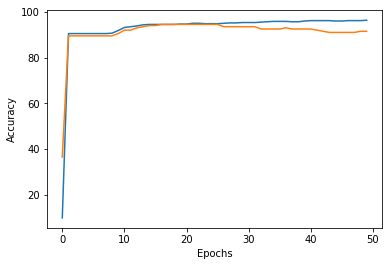

In [57]:
plt.plot(training_accuracies)
plt.plot(testing_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()